# Régression polynômiale et pileline

Le notebook compare plusieurs de modèles de régression polynômiale.

In [1]:
%matplotlib inline

In [2]:
from papierstat.datasets import load_wines_dataset
data = load_wines_dataset()
X = data.drop(['quality', 'color'], axis=1)
y = data['quality']

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

On normalise les données. Pour ce cas particulier, c'est d'autant plus important que les polynômes prendront de très grandes valeurs si cela n'est pas fait et les librairies de calculs n'aiment pas les ordres de grandeurs trop différents.

In [4]:
from sklearn.preprocessing import Normalizer
norm = Normalizer()
X_train_norm = norm.fit_transform(X_train)
X_test_norm = norm.transform(X_test)

La transformation [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) créée de nouvelles features en multipliant les variables les unes avec les autres. Pour le degré deux et trois features $a, b, c$, on obtient les nouvelles features : $1, a, b, c, a^2, ab, ac, b^2, bc, c^2$.

In [5]:
from time import clock
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

r2ts = []
r2es = []
degs = []
tts = []
models = []

for d in range(1, 5):
    begin = clock()
    pipe = make_pipeline(PolynomialFeatures(degree=d), 
                         LinearRegression())
    pipe.fit(X_train_norm, y_train)
    duree = clock() - begin
    r2t = r2_score(y_train, pipe.predict(X_train_norm))
    r2e = r2_score(y_test, pipe.predict(X_test_norm))
    degs.append(d)
    r2ts.append(r2t)
    r2es.append(r2e)
    tts.append(duree)
    models.append(pipe)
    print(d, r2t, r2e, duree)

1 0.193168565611175 0.15657975526451096 0.008275762894731331
2 0.3226815481580325 0.2743797584094798 0.015640907426260654
3 0.414912402374519 -0.606730775492738 0.13393675133244604
4 0.5961372885296189 -13581.745088113148 1.328869130511562


In [6]:
import pandas
df = pandas.DataFrame(dict(temps=tts, r2_train=r2ts, r2_test=r2es, degré=degs))
df.set_index('degré')

,r2_test,r2_train,temps
degré,,,
1,0.156580,0.193169,0.008276
2,0.274380,0.322682,0.015641
3,-0.606731,0.414912,0.133937
4,-13581.745088,0.596137,1.328869


Le polynômes de degré 2 paraît le meilleur modèle. Le temps de calcul est multiplié par 10 à chaque fois, ce qui correspond au nombre de features. On voit néanmoins que l'ajout de features croisée fonctionne sur ce jeu de données. Mais au delà de 3, la régression produit des résultats très mauvais sur la base de test alors qu'ils continuent d'augmenter sur la base d'apprentissage. Voyons cela un peu plus en détail.

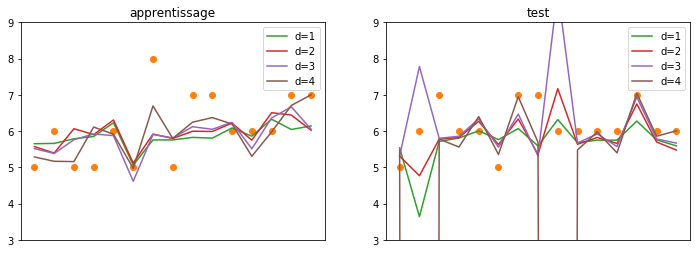

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

n = 15
ax[0].plot(y_train[:n].reset_index(), 'o')
ax[1].plot(y_test[:n].reset_index(), 'o')
ax[0].set_title('apprentissage')
ax[1].set_title('test')
for x in ax:
    x.set_ylim([3, 9])
    x.get_xaxis().set_visible(False)

for model in models:
    d = model.get_params()['polynomialfeatures__degree']
    tr = model.predict(X_train_norm[:n])
    te = model.predict(X_test_norm[:n])
    ax[0].plot(tr, label="d=%d" % d)
    ax[1].plot(te, label="d=%d" % d)
ax[0].legend()
ax[1].legend();

Le modèle de degré 4 a l'air performant sur la base d'apprentissage mais s'égare complètement sur la base de test comme s'il était surpris des valeurs rencontrées sur la base de test. On dit que le modèle fait du [sur-apprentissage](https://fr.wikipedia.org/wiki/Surapprentissage) ou [overfitting](https://en.wikipedia.org/wiki/Overfitting) en anglais. Le polynôme de degré fonctionne mieux que la régression linéaire simple. On peut se demander quelles sont les variables croisées qui ont un impact sur la performance. On utilise le modèle [statsmodels](http://www.statsmodels.org/stable/index.html).

In [8]:
poly = PolynomialFeatures(degree=2)
poly_feat_train = poly.fit_transform(X_train_norm)
poly_feat_test = poly.fit_transform(X_test_norm)

In [9]:
from statsmodels.regression.linear_model import OLS
model = OLS(y_train, poly_feat_train)
results = model.fit()
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.312     
Dependent Variable: quality          AIC:                10755.9352
Date:               2018-02-04 16:33 BIC:                11255.7622
No. Observations:   4872             Log-Likelihood:     -5301.0   
Df Model:           76               F-statistic:        30.06     
Df Residuals:       4795             Prob (F-statistic): 0.00      
R-squared:          0.323            Scale:              0.52422   
-------------------------------------------------------------------
          Coef.     Std.Err.     t    P>|t|     [0.025     0.975]  
-------------------------------------------------------------------
const    -660.6332  1934.9469 -0.3414 0.7328  -4454.0170  3132.7507
x1         20.8261    24.7664  0.8409 0.4004    -27.7274    69.3795
x2       -733.4664   172.6791 -4.2476 0.0000  -1071.9967  -394.9361
x3       -166.5645   196.7029 -0.8468 0.3972   -552.1924   219.0634
x4          1.7475    13.0237  0.1342 0.8933    -23.7848    27.2798
x5      -1317.7890   749.5479 -1.7581 0.0788  -2787.2468   151.6689
x6         38.3039     8.1803  4.6825 0.0000     22.2669    54.3410
x7         68.4267    22.5265  3.0376 0.0024     24.2645   112.5890
x8      -2314.1573   777.9942 -2.9745 0.0029  -3839.3829  -788.9317
x9        122.5769   208.8289  0.5870 0.5572   -286.8236   531.9774
x10      -352.8457   167.9020 -2.1015 0.0356   -682.0106   -23.6807
x11       281.7742    25.1868 11.1874 0.0000    232.3965   331.1520
x12       628.9783  1926.9088  0.3264 0.7441  -3148.6471  4406.6038
x13       214.6077   149.6615  1.4340 0.1517    -78.7975   508.0129
x14      -223.0886   199.7093 -1.1171 0.2640   -614.6104   168.4332
x15         9.5482    21.2578  0.4492 0.6533    -32.1268    51.2232
x16      -336.5239   575.6442 -0.5846 0.5588  -1465.0506   792.0028
x17       -12.9838     9.7701 -1.3289 0.1839    -32.1376     6.1701
x18       -16.1568    21.8694 -0.7388 0.4601    -59.0308    26.7172
x19       525.8351  1154.6770  0.4554 0.6488  -1737.8616  2789.5318
x20        17.8422   284.3381  0.0627 0.9500   -539.5909   575.2753
x21        40.7178   146.8406  0.2773 0.7816   -247.1572   328.5928
x22       -76.1554    26.2789 -2.8980 0.0038   -127.6740   -24.6367
x23       547.9597  2097.1174  0.2613 0.7939  -3563.3527  4659.2721
x24      1652.5595  1574.0409  1.0499 0.2938  -1433.2828  4738.4019
x25      -248.6916   127.2535 -1.9543 0.0507   -498.1667     0.7836
x26      1998.3980  4602.6479  0.4342 0.6642  -7024.9038 11021.6997
x27       188.0104    65.4123  2.8742 0.0041     59.7722   316.2486
x28       539.0396   153.4093  3.5137 0.0004    238.2870   839.7922
x29     -4198.6690  5226.9561 -0.8033 0.4219 -14445.9013  6048.5633
x30      1246.0561  1590.7675  0.7833 0.4335  -1872.5780  4364.6903
x31     -2775.3105  1263.3486 -2.1968 0.0281  -5252.0534  -298.5675
x32       583.6156   183.4598  3.1812 0.0015    223.9502   943.2810
x33      1680.8180  2232.7980  0.7528 0.4516  -2696.4906  6058.1266
x34      -137.8173   169.5591 -0.8128 0.4164   -470.2310   194.5964
x35     -1897.1069  5135.8144 -0.3694 0.7119 -11965.6597  8171.4460
x36        78.9253    80.7852  0.9770 0.3286    -79.4508   237.3014
x37       116.8228   174.5925  0.6691 0.5035   -225.4586   459.1042
x38     14446.9228  7939.2842  1.8197 0.0689  -1117.7171 30011.5626
x39     -5538.7646  2136.1555 -2.5929 0.0095  -9726.6096 -1350.9196
x40        90.6629  1516.6359  0.0598 0.9523  -2882.6393  3063.9651
x41       560.0868   232.3640  2.4104 0.0160    104.5468  1015.6268
x42       618.1551  1934.8345  0.3195 0.7494  -3175.0083  4411.3185
x43      2553.7667   736.4672  3.4676 0.0005   1109.9532  3997.5803
x44        -8.2338     4.8177 -1.7091 0.0875    -17.6787     1.2112
x45         4.9431    11.9396  0.4140 0.6789    -18.4641    28.3502
x46       782.3023   693.

Ce n'est pas très lisible. Il faut ajouter le nom de chaque variable et recommencer.

In [10]:
names = poly.get_feature_names(input_features=data.columns[:-2])
pft = pandas.DataFrame(poly_feat_train, columns=names)
pft.head()

,1,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,...,density^2,density pH,density sulphates,density alcohol,pH^2,pH sulphates,pH alcohol,sulphates^2,sulphates alcohol,alcohol^2
0,1.0,0.062863,0.003880,0.003648,0.008537,0.000287,0.178501,0.977874,0.007713,0.024913,...,0.000059,0.000192,0.000025,0.000652,0.000621,0.000081,0.002107,0.000011,0.000276,0.007156
1,1.0,0.091894,0.002188,0.003391,0.030631,0.000591,0.175036,0.973638,0.010876,0.032382,...,0.000118,0.000352,0.000054,0.001130,0.001049,0.000159,0.003365,0.000024,0.000512,0.010801
2,1.0,0.044552,0.002032,0.001876,0.139128,0.000461,0.179772,0.969205,0.007798,0.025793,...,0.000061,0.000201,0.000030,0.000616,0.000665,0.000101,0.002036,0.000015,0.000309,0.006232
3,1.0,0.057086,0.000976,0.002554,0.069856,0.000466,0.300455,0.946433,0.007486,0.024111,...,0.000056,0.000180,0.000022,0.000540,0.000581,0.000071,0.001739,0.000009,0.000211,0.005200
4,1.0,0.125899,0.006505,0.009862,0.075540,0.001406,0.377698,0.881296,0.020889,0.071133,...,0.000436,0.001486,0.000289,0.004821,0.005060,0.000985,0.016419,0.000192,0.003197,0.053276


In [11]:
results.summary2(xname=pft.columns)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Ordinary least squares
====================================================================================================
Model:                         OLS                         Adj. R-squared:                0.312     
Dependent Variable:            quality                     AIC:                           10755.9352
Date:                          2018-02-04 16:33            BIC:                           11255.7622
No. Observations:              4872                        Log-Likelihood:                -5301.0   
Df Model:                      76                          F-statistic:                   30.06     
Df Residuals:                  4795                        Prob (F-statistic):            0.00      
R-squared:                     0.323                       Scale:                         0.52422   
----------------------------------------------------------------------------------------------------
                                           Coef.     Std.Err.     t    P>|t|     [0.025     0.975]  
----------------------------------------------------------------------------------------------------
1                                         -660.6332  1934.9469 -0.3414 0.7328  -4454.0170  3132.7507
fixed_acidity                               20.8261    24.7664  0.8409 0.4004    -27.7274    69.3795
volatile_acidity                          -733.4664   172.6791 -4.2476 0.0000  -1071.9967  -394.9361
citric_acid                               -166.5645   196.7029 -0.8468 0.3972   -552.1924   219.0634
residual_sugar                               1.7475    13.0237  0.1342 0.8933    -23.7848    27.2798
chlorides                                -1317.7890   749.5479 -1.7581 0.0788  -2787.2468   151.6689
free_sulfur_dioxide                         38.3039     8.1803  4.6825 0.0000     22.2669    54.3410
total_sulfur_dioxide                        68.4267    22.5265  3.0376 0.0024     24.2645   112.5890
density                                  -2314.1573   777.9942 -2.9745 0.0029  -3839.3829  -788.9317
pH                                         122.5769   208.8289  0.5870 0.5572   -286.8236   531.9774
sulphates                                 -352.8457   167.9020 -2.1015 0.0356   -682.0106   -23.6807
alcohol                                    281.7742    25.1868 11.1874 0.0000    232.3965   331.1520
fixed_acidity^2                            628.9783  1926.9088  0.3264 0.7441  -3148.6471  4406.6038
fixed_acidity volatile_acidity             214.6077   149.6615  1.4340 0.1517    -78.7975   508.0129
fixed_acidity citric_acid                 -223.0886   199.7093 -1.1171 0.2640   -614.6104   168.4332
fixed_acidity residual_sugar                 9.5482    21.2578  0.4492 0.6533    -32.1268    51.2232
fixed_acidity chlorides                   -336.5239   575.6442 -0.5846 0.5588  -1465.0506   792.0028
fixed_acidity free_sulfur_dioxide          -12.9838     9.7701 -1.3289 0.1839    -32.1376     6.1701
fixed_acidity total_sulfur_dioxide         -16.1568    21.8694 -0.7388 0.4601    -59.0308    26.7172
fixed_acidity density                      525.8351  1154.6770  0.4554 0.6488  -1737.8616  2789.5318
fixed_acidity pH                            17.8422   284.3381  0.0627 0.9500   -539.5909   575.2753
fixed_acidity sulphates                     40.7178   146.8406  0.2773 0.7816   -247.1572   328.5928
fixed_acidity alcohol                      -76.1554    26.2789 -2.8980 0.0038   -127.6740   -24.6367
volatile_acidity^2                         547.9597  2097.1174  0.2613 0.7939  -3563.3527  4659.2721
volatile_acidity citric_acid              1652.5595  1574.0409  1.0499 0.2938  -1433.2828  4738.4019
volatile_acidity residual_sugar           -248.6916   127.2535 -1.9543 0.0507   -498.1667     0.7836
volatile_acidity chlorides                1998.3980  4602.6479  0.4342 0.6642  -7024.9038 11021.6997
volatile_acidity free_sulfur_dioxide       188.

On ne garde que celles dont la [p-value](http://www.xavierdupre.fr/app/mlstatpy/helpsphinx/c_metric/pvalues.html) est inférieur à 0.05.

In [12]:
pval = results.pvalues.copy()
pval[pval <= 0.05]

x2     2.201979e-05
x6     2.912509e-06
x7     2.397429e-03
x8     2.949125e-03
x10    3.564934e-02
x11    1.062903e-28
x22    3.772895e-03
x27    4.067902e-03
x28    4.459324e-04
x31    2.808320e-02
x32    1.476207e-03
x39    9.546901e-03
x41    1.597307e-02
x43    5.297601e-04
x52    4.975523e-02
x58    3.459212e-05
x59    1.708381e-03
x62    1.553047e-12
x64    3.833776e-02
x66    1.252690e-02
x67    6.178789e-21
x71    1.914593e-02
x72    1.715228e-03
x74    1.329806e-03
x76    6.490156e-03
dtype: float64

In [13]:
pval.index = pft.columns
pval[pval <= 0.05]

volatile_acidity                            2.201979e-05
free_sulfur_dioxide                         2.912509e-06
total_sulfur_dioxide                        2.397429e-03
density                                     2.949125e-03
sulphates                                   3.564934e-02
alcohol                                     1.062903e-28
fixed_acidity alcohol                       3.772895e-03
volatile_acidity free_sulfur_dioxide        4.067902e-03
volatile_acidity total_sulfur_dioxide       4.459324e-04
volatile_acidity sulphates                  2.808320e-02
volatile_acidity alcohol                    1.476207e-03
citric_acid pH                              9.546901e-03
citric_acid alcohol                         1.597307e-02
residual_sugar chlorides                    5.297601e-04
chlorides total_sulfur_dioxide              4.975523e-02
free_sulfur_dioxide total_sulfur_dioxide    3.459212e-05
free_sulfur_dioxide density                 1.708381e-03
free_sulfur_dioxide alcohol    

Le modèle fonctionne mieux mais il est plus compliqué de savoir si la contribution de l'alcool est corrélée positivement avec la qualité car l'alcool apparaît dans plus d'une variable.